<center><h1> Log based client recognition using Ensemble Methods</center></h1>

<a id="top"></a>

#### A demonstration and exploration by Noam Kaplan. 
- Email:    Noam.Kaplan85@gmail.com
- Linkedin: https://il.linkedin.com/in/noam-kaplan-22b46683

### Table of contents: 

- [Introduction: ](#Introduction:)
- [1. Data generation](#1. Data generation)
- [2. Exploring the data](#2. Exploring the data)
- [3. Client recognition](#3. Client recognition) 
    - [3.1. Transformers](#3.1 Transformers)
    - [3.2. Simple pipelines](#3.2 Simple pipelines)
    - [3.3. Feature Unions](#3.3 Feature Unions)
    - [3.4 Simple Ensembling Method](#3.4 Simple Ensembling Method)
    
- [References](#References)

<a id='Introduction:'></a>

## Introduction: 

[[back to top](#top)]

In The following demonstration I will first create Data in the form of entry logs. Each enrty will hold a few different values, corresponding to time and date of entrance, Total stay time, viewed categoreis, etc. Each of these values will be generated in a different manner, introducing a certain amount of randomality. 

Besides these values, each generated log will be associated with a specific client id. For clarity, let's assume the data was collected on instances when the client logged in using his username and password. In this tutorial I will describe the process of learning to identify the specific client in a session He has not logged on in. 

Disclaimer: 

At the end of the tutorial I have added a list of incredible tutorials I have been working with for a while. They were all used in the preparation of this tutorial, with some modification as needed. They were all used to a slightly different end than purposed for. I have added referrences into the notebook at specific points as well. 
    - I have not yet finished clearly documenting this code. If any questions arise, please contact me. 
    - I will appreciate any corrections or suggestions for improvment. 

<a id='1. Data generation'></a>

## 1. Data generation

[[back to top](#top)]

In [2]:
from sklearn.feature_extraction.text  import CountVectorizer
from sklearn.naive_bayes              import MultinomialNB
from sklearn.linear_model             import LinearRegression, LogisticRegression
from sklearn.ensemble                 import RandomForestRegressor
from sklearn.pipeline                 import Pipeline, FeatureUnion
from sklearn.base                     import TransformerMixin
from sklearn.cross_validation         import KFold, train_test_split 
from sklearn.metrics                  import confusion_matrix, f1_score
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
#Define variable n for number of logs entries for each client. 
n = 10000
predict_by = 'Client'

#### We start by generating the data from which the logs will be comprised. In order to make the task of client recognition interesting, values generated for either of our two different users will not form disjoint sets. 

#### Since the data was generated in an ad-hoc manner to fit graphs I had planned, I suggest jumping straight to [2. Exploring the data](#2. Exploring the data)

In [4]:
# Total stay - Randomly distributed from uniform distributions with some overlapping. 
# Already Numpy array
def total_stay_gen(low_lim, high_lim, size):
    total_stay = np.random.uniform(low=low_lim, high=high_lim, size=size)
    return total_stay

In [5]:
def multiple_gausians(locations, scales, sizes): 
    num_centers = len(locations)
    sum_of_gausians = np.asarray([])
    for i in range(num_centers): 
        sum_of_gausians = np.concatenate((sum_of_gausians, gausian_feature(loc=locations[i], scale=scales[i], size=sizes[i])))
    return sum_of_gausians

# New data for data oservation:
def gausian_feature(loc, scale, size):
    return np.random.normal(loc, scale, size) 
    

In [6]:
def gen_gausian_vector_params(client, n):
    v1 = [[ 100,  30, -10, -30], [10, 4, 3, 3], [n-int(5*n/12)-int(n/12)-int(n/12), int(5*n/12), int(n/12), int(n/12)]]
    v2 = [[-100, -30,  10,  30], [10, 4, 3, 3], [n-int(5*n/12)-int(n/12)-int(n/12), int(5*n/12), int(n/12), int(n/12)]]
    if client == 'Client1':
        return v1
    if client == 'Client2':
        return v2

In [7]:
def gen_gaus(client, size):
    locations, scales, sizes = gen_gausian_vector_params(client, size)
    return multiple_gausians(locations, scales, sizes)

In [8]:
def create_log_list(entry_time=None, total_stay=[0,5], client=None, categories=None, n=n):
    if client == 'Client1':
        entry_time, categories, ts, cid = ('1/1/2011', ['Electric appliance', 'Climbing equipment', 'etc'], [1,7], 1) 
    if client == 'Client2': 
        entry_time, categories, ts, cid = ('15/7/2011 12:00:00', ["Women's clothing", 'Jewlery', 'etc'], [5,11], 2)
        
    # Create n different time stamps for each user, groups overlap as will be shown in plot. 
    timeStamps = pd.date_range(entry_time, periods=n, freq='H')
    # Categories - group of categories, two disjoint and one shared ('etc').   
#    catagories_vec = np.asarray([categories[0]]*int(n/3) + 
#                            [categories[1]]*int(n/3) + 
#                            [categories[2]]*int(n-(2*int(n/3))))
    # Categories - group of categories, two disjoint and one shared ('etc').  
    # Mixing list for more randomality
    categories_vec = [categories[0]]*int(n/3) + [categories[1]]*int(n/3) + [categories[2]]*int(n-(2*int(n/3)))
    np.random.shuffle(categories_vec)
    categories_vec = np.asarray(categories_vec)
   
    total_stay = total_stay_gen(ts[0], ts[1], n)

    # New data for data oservation: 
    gausian_feature = gen_gaus(client, n)
    #gausian_feature = np.random.normal(loc=110, scale=13, size = n) 
    
    return [timeStamps, categories_vec, total_stay, gausian_feature]

In [9]:
# Create dictionary with data generated for Client1.
#Create DataFrame object for Client1.  
def feature_df(features, cid):
    if cid == 1: 
        ran = [1, n+1]
    if cid == 2: 
        ran= [n+2, 2*n+2]
    dict1 = {'Entry_times'     : features[0],
            'Categories'      : features[1], 
            'Total_stay'      : features[2],
            'Gausian_feature' : features[3],
            'Client'          : cid*np.ones(n)} 
    cols = ['Entry_times', 'Categories','Total_stay', 'Gausian_feature', 'Client']
    df = pd.DataFrame(dict1, index=range(ran[0],ran[1]), columns=cols)
    return df

In [10]:
#Create single data frame with both clients logs. Returned data is mixed using reindex. 
def create_log():
    df1 = feature_df(create_log_list(client='Client1'), 1)
    df2 = feature_df(create_log_list(client='Client2'), 2)
    # Create DataFrame with data collected about both users using concat. Data is sorted.
    data = pd.concat([df1, df2], ignore_index=True)
    data = data.reindex(np.random.permutation(data.index))
    return data

<a id='2. Exploring the data'></a>

### 2. Exploring the data

[[back to top](#top)]

#### Our first step will be to create and view the data logs created by the above functions. 

In [11]:
data = create_log() 
# Print out first 10 entries of new table. 
data[:10]

,Entry_times,Categories,Total_stay,Gausian_feature,Client
5325,2011-08-10 21:00:00,Electric appliance,6.297837,34.306775,1
8523,2011-12-22 03:00:00,etc,4.983233,-7.034270,1
15403,2012-02-25 15:00:00,etc,9.513337,-31.343766,2
2152,2011-03-31 16:00:00,etc,4.039262,98.370546,1
19644,2012-08-20 08:00:00,Women's clothing,5.910105,26.894948,2
7018,2011-10-20 10:00:00,Climbing equipment,3.255399,28.307711,1
19226,2012-08-02 22:00:00,etc,9.466290,33.658261,2
4614,2011-07-12 06:00:00,Electric appliance,2.847985,25.183459,1
18578,2012-07-06 22:00:00,Jewlery,9.392222,6.186682,2
16892,2012-04-27 16:00:00,Women's clothing,8.221460,-27.819518,2


#### By viewing the first 10 entries alone, a few matters become clear:
    - Indexes are not sequential or orderd. After creating the logs I arbitrarily split the data, in order to avoid wrong conclusions. This is crucial for cross-validation, so that when splitting data, all groups will have the same distribution. (Since using K-fold this is not necessary. :) )
    - Each row represents one entry and a few different kinds of values of information. 
    - Each enrty is associated with one of two Clients. 

#### This part of the process is a critical stage for many reasons. For starters, since this is not real data but specifically generated, It is necessary to verify that the data was properly generated. 

#### Beyond this task specific reason, understanding the data is perhaps the most crucial phase in choosing the correct method with which an individual objective can be persued. This will become clearly evident while comparing results of classifiers in part 3. 

#### As a first means of gaining insight, pandas package offers us the simple to use and informative describe function. 

In [12]:
pd.DataFrame(data['Client'].describe())

,Client
count,20000.000000
mean,1.500000
std,0.500013
min,1.000000
25%,1.000000
50%,1.500000
75%,2.000000
max,2.000000


#### It is evident from the mean value (not only) that the enries are split fairly as half originating from Client 1 and half from Client 2. When exploring the column 'Entry_times' on the other hand, a different picture is evident. 

In [13]:
pd.DataFrame(data['Entry_times'].describe())

,Entry_times
count,20000
unique,14692
top,2011-09-21 10:00:00
freq,2
first,2011-01-01 00:00:00
last,2012-09-04 03:00:00


#### Note that out of all 20000 logs, only 14692 are unique (each entry time per client is unique), meaning ~26.5% percent of the entry times are shared between clients. 

####  My intention was too create entries where each feature collected of an entry will be very informative in most cases, if it was sampled out of the disjoint part of the domain, or not informative if it originated from the overlapping part of the domains. 

#### As can be seen in the plot the histogram below, total stay values overlap in one segment in the middle. By observing only this parameter, in the great majority of cases (around 80%) a correct decision could be reached. The same is true for other parameters as well as shown below. 

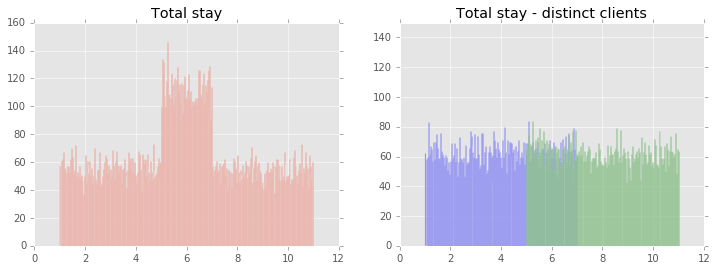

In [14]:
C1_stay = data.Total_stay[(data['Client'] == 1)]
C2_stay = data.Total_stay[(data['Client'] == 2)]

fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].hist(data.Total_stay,  bins=300, alpha=1)
axes[0].set_title("Total stay");

axes[1].hist(C1_stay,bins=160, label='Client1', color='blue', alpha=0.7);
axes[1].set_ylim([0, 150])
axes[1].hist(C2_stay,bins=160, alpha=0.7, color='green', )
axes[1].set_title("Total stay - distinct clients");

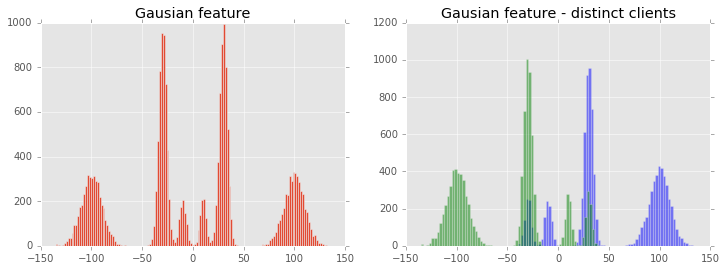

In [82]:
C1_gaus = data.Gausian_feature[(data['Client'] == 1)]
C2_gaus = data.Gausian_feature[(data['Client'] == 2)]

fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].hist(data.Gausian_feature,  bins=140)
axes[0].set_title("Gausian feature")

axes[1].set_title("Gausian feature - distinct clients")
axes[1].hist(C1_gaus, bins=70, label='Client1', color='blue', alpha=0.5)
axes[1].hist(C2_gaus, bins=70, alpha=0.5, color='green', label=r'$Client2$');

Note overlapping part of the green and blue data under the high columns. 

Through carful observation of the data, We can estimate that even a simple algorithm can reach good recognition preformance based on the disjoint part of the data alone. We will proceed to validate this assumption. 

<a id='3. Client recognition'></a>

### 3. Client Recognition

[[back to top](#top)]

In this part of the tutorial, We will explore different classifing methods, their advantages and disadvantages and mostly try to match the correct scheme to the given data. 

<a id='3.1 Transformers'></a>

#### 3.1 Transformers

[[back to top](#top)]

Inorder to facilitate different properties of our data and easy work with Sklearn-pipelines,  three new objects must be defined. I will not expand on the subject by highly recommend <a href="http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html">Zac Stewart's tutorial</a> on pipelines and featureUnions. 


In [16]:
#Reshaper: 
class Reshaper(TransformerMixin):

    def __init__(self, shape=[1,1]):
        self.shape = shape

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def transform(self, X, **transform_params):
        return X.reshape(self.shape[0],self.shape[1])

    def fit(self, X, y=None, **fit_params):
        return self

In [17]:
#Column extractor for choosing column out of data frame: 
class ColumnExtractor(TransformerMixin):

    def __init__(self, columns=[]):
        self.columns = columns

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def transform(self, X, **transform_params):
        return X[self.columns]

    def fit(self, X, y=None, **fit_params):
        return self

In [18]:
class EntryTimesTransformer(TransformerMixin):

    def transform(self, X, **transform_params):
        return X.apply(lambda x: x.value)

    def fit(self, X, y=None, **fit_params):
        return self


<a id='3.2 Simple pipelines'>

#### 3.2 Simple pipelines

[[back to top](#top)]

In order to test our hypothesis that for most entries a correct prediction could be reached according to each individual feature, I have created pipelines for predicting clients according to one single feature. On some cases I alson compared to different classifiers on the same task. 

In [129]:
# Single feature Pipelines with LinearRegression classifier. 

pipeline_categories_LR = Pipeline([
    ('extract_cat', ColumnExtractor('Categories')),
    ('vectorizer',  CountVectorizer()),
    ('classifier',  LinearRegression()) ])

pipeline_Entry_times_LR = Pipeline([
    ('extract_ts', ColumnExtractor('Entry_times')),
    ('time_trans', EntryTimesTransformer()), 
    ('reshpe',     Reshaper([-1,1])),   
    ('classifier', LinearRegression()) ])

pipeline_Total_stay_LR = Pipeline([
    ('extract_ts', ColumnExtractor('Total_stay')),
    ('reshpe',     Reshaper([-1,1])),   
    ('classifier', LinearRegression()) ])

pipeline_Gausian_LR = Pipeline([
    ('extract_Gausian', ColumnExtractor('Gausian_feature')),
    ('reshpe',     Reshaper([-1,1])),   
    ('classifier', LinearRegression()) ])


In [130]:
PL_single_feature_LR = {'Categories_LR' : pipeline_categories_LR, 
                        'Entry_times_LR': pipeline_Entry_times_LR, 
                        'Total_stay_LR' : pipeline_Total_stay_LR, 
                        'Gausian_LR'    : pipeline_Gausian_LR,     }

Drawing again from  <a href="http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html">Zac Stewart's tutorial</a> , this time on document classification. The function test_pipelines is based on code originating from the tutorial, remixed into a recallable function, with some extra functionality. 

Using Scikit-learn's K-fold, pipelines are trained on 3/4 of the data, and then predict the client of the remaining quarter. This process is repeated for times, thus creating a prediction for every log. If variable add_pred_cols is set to True, the function will also return the data, with a prediction column add for every classifier used. This functionality will become usefull when ensembling. 

In [131]:
def test_pipelines(data, pipelines_dict, n_folds_user=4, predict_by='Client', verbose=True, add_pred_cols=False):
    if add_pred_cols: 
        copy_data = data.copy(deep=True)
    for pipeline_name in pipelines_dict:
        pipeline = pipelines_dict[pipeline_name]
        k_fold = KFold(n=len(data), n_folds=n_folds_user)
        scores = []
        confusion = np.array([[0, 0], [0, 0]])
        for train_indices, test_indices in k_fold:
            train_feat = data.iloc[train_indices]
            train_client = data.iloc[train_indices][predict_by].values

            test_feat = data.iloc[test_indices]
            test_client = data.iloc[test_indices][predict_by].values

            pipeline.fit(train_feat, train_client)
            predictions = pipeline.predict(test_feat)

            confusion += confusion_matrix(test_client, predictions.round())
            score = f1_score(test_client, predictions.round(), pos_label=1)
            score += f1_score(test_client, predictions.round(), pos_label=2)            
            score /=2
            scores.append(score)
            
            if add_pred_cols:
                copy_data.loc[test_feat.index,pipeline_name] = pd.Series(predictions.round(), index=test_feat.index)
        
        if verbose: 
            print('    Pipeline: ', pipeline_name)
            print('    Score:', sum(scores)/len(scores))
            print('    Confusion matrix:')
            print('    ', confusion[0], '\n', '   ', confusion[1])
            missClassified = confusion[0][1]+confusion[1][0]
            print('    Misclassified: ', missClassified, ','+'{0:2.2f}'.format((missClassified / int(2*n) * 100))+'%')
            print('*'*35)
    if add_pred_cols:
        return copy_data

In [132]:
data_added_columns = test_pipelines(data, PL_single_feature_LR, verbose=True, add_pred_cols=True)

    Pipeline:  Total_stay_LR
    Score: 0.829124055196
    Confusion matrix:
     [8327 1673] 
     [1744 8256]
    Misclassified:  3417 ,17.09%
***********************************
    Pipeline:  Categories_LR
    Score: 0.825932823534
    Confusion matrix:
     [9153  847] 
     [2544 7456]
    Misclassified:  3391 ,16.96%
***********************************
    Pipeline:  Gausian_LR
    Score: 0.833427835314
    Confusion matrix:
     [8335 1665] 
     [1666 8334]
    Misclassified:  3331 ,16.66%
***********************************
    Pipeline:  Entry_times_LR
    Score: 0.73434018125
    Confusion matrix:
     [7344 2656] 
     [2657 7343]
    Misclassified:  5313 ,26.57%
***********************************


As expected, using individal features as input for the classifiers enabled correct identification in most cases. Some Features proved more useful than others - resulting of course, in choices I made when generating the data. When Comparing Classifiers on the same feature, some classifiers returned better results, though in terms of order of magnitude, results did not vary greatly. As before, I will address the reasons for some of these differeces when tackling Ensembling. 

Due to the interesting nature of the Gausian feature's samples, I have decided to comapre another classifier on the same data. As can be seen in the plot of the Gausian freture above, decisions cannot be taken simply by dividing the area into two. I will delve deeper into the nature of these differences later on, when using ensembles, but the finer point can be made clear right now. 

In [133]:
#Pipeline using only Gausian feature, with added 
pipeline_Gausian_RandomForest = Pipeline([
    ('extract_Gausian', ColumnExtractor('Gausian_feature')),
    ('reshpe',     Reshaper([-1,1])),   
    ('classifier', RandomForestRegressor(n_jobs=-1, n_estimators=300, min_samples_split=10, max_features=1))
    ])

In [134]:
PL_Comparing_gausian = {'Gausian_RandomForest'        : pipeline_Gausian_RandomForest, 
                        'Gausian_LinearRegression'    : pipeline_Gausian_LR,     }

In [135]:
data_added_columns = test_pipelines(data_added_columns, PL_Comparing_gausian, verbose=True, add_pred_cols=True)

    Pipeline:  Gausian_LinearRegression
    Score: 0.833427835314
    Confusion matrix:
     [8335 1665] 
     [1666 8334]
    Misclassified:  3331 ,16.66%
***********************************
    Pipeline:  Gausian_RandomForest
    Score: 0.891993682074
    Confusion matrix:
     [8907 1093] 
     [1067 8933]
    Misclassified:  2160 ,10.80%
***********************************


Without going into the difference between classifiers, it is clear that using RandomeForest in this case, is more effective. 

([<matplotlib.axis.XTick at 0x7f0ef1fb91d0>,
 <a list of 2 Text xticklabel objects>)

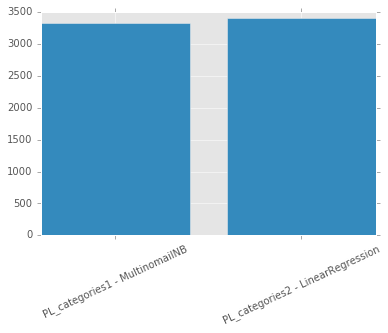

In [136]:
#TODO: add some plotting of results
num_wrong_dict = {'PL_categories1 - MultinomailNB':3334, 'PL_categories2 - LinearRegression': 3410}

plt.bar(range(len(num_wrong_dict)), num_wrong_dict.values(), align='center')
plt.xticks(range(len(num_wrong_dict)), num_wrong_dict.keys(), rotation=25)

</a><a id='3.3 Feature Unions'></a>

#### 3.3 Feature Unions

[[back to top](#top)]

As expected, for the majority of cases, one feature is enough for correct classification, though in many cases it is not. An important fact that can be used to our advantage is that while a log entry might have a value that is not informative in one column, since columns are independent, it is likely some of the other features will be informative. To test this hypothesis I will create pipelines using FeatureUnions, thus using more information per desicion and hopefully improve performance. 

For the sake of simplicity and code length and readability, I will use RandomForest classifier, with the same parameters in all pipelines. 

In [137]:
pipeline_double1 = Pipeline([
        ('features', FeatureUnion([
            ('entry', Pipeline([
                ('extract_ES', ColumnExtractor('Entry_times')),
                ('time_trans', EntryTimesTransformer()), 
                ('reshpe',     Reshaper([-1,1]))
            ])),
            ('total_stay', Pipeline([
                ('extract_TS', ColumnExtractor('Total_stay')),
                ('reshpe',     Reshaper([-1,1])), 
            ]))        
        ])),
        ('classifier', RandomForestRegressor(n_jobs=-1, n_estimators=300, min_samples_split=10, max_features=2))
    ])

pipeline_double2 = Pipeline([
        ('features', FeatureUnion([
            ('entry', Pipeline([
                ('extract_ES', ColumnExtractor('Entry_times')),
                ('time_trans', EntryTimesTransformer()), 
                ('reshpe',     Reshaper([-1,1]))
            ])),
            ('Gausian', Pipeline([
                ('extract_Gausian', ColumnExtractor('Gausian_feature')),
                ('reshpe',     Reshaper([-1,1])),   
            ]))        
        ])),
        ('classifier', RandomForestRegressor(n_jobs=-1, n_estimators=300, min_samples_split=10, max_features=2))
    ])

pipeline_double3 = Pipeline([
        ('features', FeatureUnion([
            ('Gausian', Pipeline([
                ('extract_Gausian', ColumnExtractor('Gausian_feature')),
                ('reshpe',     Reshaper([-1,1])),   
            ])),
            ('total_stay', Pipeline([
                ('extract_TS', ColumnExtractor('Total_stay')),
                ('reshpe',     Reshaper([-1,1])), 
            ]))        
        ])),
        ('classifier', RandomForestRegressor(n_jobs=-1, n_estimators=300, min_samples_split=10, max_features=2))
    ])



In [92]:
Double_pipelines = {'Double: Entry Times, Total Stay': pipeline_double1,
                   'Double: Entry Times, Gausian'    : pipeline_double2, 
                   'Double: Gausian, Total Stay'     : pipeline_double3}

In [144]:
data_added_columns = test_pipelines(data_added_columns, Double_pipelines, verbose=True, add_pred_cols=True)

    Pipeline:  Double: Entry Times, Total Stay
    Score: 0.908284474231
    Confusion matrix:
     [9050  950] 
     [ 884 9116]
    Misclassified:  1834 ,9.17%
***********************************
    Pipeline:  Double: Gausian, Total Stay
    Score: 0.969145391183
    Confusion matrix:
     [9689  311] 
     [ 306 9694]
    Misclassified:  617 ,3.08%
***********************************
    Pipeline:  Double: Entry Times, Gausian
    Score: 0.958498627392
    Confusion matrix:
     [9586  414] 
     [ 416 9584]
    Misclassified:  830 ,4.15%
***********************************


Simply put, using more features allows making a desicion based on more information, leads to improve results. We will inspect Tree features as well. 

In [95]:
#Three features:
pipeline_triple1 = Pipeline([
        ('features', FeatureUnion([
            ('Gausian', Pipeline([
                ('extract_cat', ColumnExtractor('Gausian_feature')),
                ('reshpe',     Reshaper([-1,1]))
            ])),
            ('entry', Pipeline([
                ('extract_ts', ColumnExtractor('Entry_times')),
                ('time_trans', EntryTimesTransformer()), 
                ('reshpe',     Reshaper([-1,1]))
            ])),
            ('total_stay', Pipeline([
                ('extract_ts', ColumnExtractor('Total_stay')),
                ('reshpe',     Reshaper([-1,1])), 
            ]))        
        ])),
        ('classifier', RandomForestRegressor(n_jobs=-1, n_estimators=300, min_samples_split=10, max_features=3))
    ])

pipeline_triple2 = Pipeline([
        ('features', FeatureUnion([
            ('Gausian', Pipeline([
                ('extract_gaus', ColumnExtractor('Gausian_feature')),
                ('reshpe',     Reshaper([-1,1]))
            ])),
            ('entry', Pipeline([
                ('extract_ES', ColumnExtractor('Entry_times')),
                ('time_trans', EntryTimesTransformer()), 
                ('reshpe',     Reshaper([-1,1]))
            ])),
            ('Categories', Pipeline([
                ('extract_CAT', ColumnExtractor('Categories')),
                ('vectorizer',  CountVectorizer()),
            ])), 
        ])),
        ('classifier', RandomForestRegressor(n_jobs=-1, n_estimators=300, min_samples_split=10, max_features=3))
    ])

pipeline_triple3 = Pipeline([
        ('features', FeatureUnion([
            ('Categories', Pipeline([
                ('extract_CAT', ColumnExtractor('Categories')),
                ('vectorizer',  CountVectorizer()),
            ])),
            ('entry', Pipeline([
                ('extract_ES', ColumnExtractor('Entry_times')),
                ('time_trans', EntryTimesTransformer()), 
                ('reshpe',     Reshaper([-1,1]))
            ])),
            ('total_stay', Pipeline([
                ('extract_TS', ColumnExtractor('Total_stay')),
                ('reshpe',     Reshaper([-1,1])), 
            ]))        
        ])),
        ('classifier', RandomForestRegressor(n_jobs=-1, n_estimators=300, min_samples_split=10, max_features=3))
    ])

In [96]:
Triple_Pipelines = {'Triple: Gausian, Entry Times, Total Stay'   : pipeline_triple1,
                    'Triple: Gausian, Entry Times, Categories'   : pipeline_triple2, 
                    'Triple: Categories, Entry_times, Total Stay': pipeline_triple3}

In [147]:
data_added_columns = test_pipelines(data_added_columns, Triple_Pipelines, verbose=True, add_pred_cols=True)

    Pipeline:  Triple: Gausian, Entry Times, Total Stay
    Score: 0.987898653067
    Confusion matrix:
     [9880  120] 
     [ 122 9878]
    Misclassified:  242 ,1.21%
***********************************
    Pipeline:  Triple: Gausian, Entry Times, Categories
    Score: 0.98614894783
    Confusion matrix:
     [9841  159] 
     [ 118 9882]
    Misclassified:  277 ,1.39%
***********************************
    Pipeline:  Triple: Categories, Entry_times, Total Stay
    Score: 0.970346379559
    Confusion matrix:
     [9687  313] 
     [ 280 9720]
    Misclassified:  593 ,2.96%
***********************************


Again, using more features improved our decision making. The next obvious step will be to use all features combined. Let's do that. 

In [101]:
all_features = FeatureUnion([
            ('entry', Pipeline([
                ('extract_ts', ColumnExtractor('Entry_times')),
                ('time_trans', EntryTimesTransformer()), 
                ('reshpe',     Reshaper([-1,1]))
            ])),
            ('total_stay', Pipeline([
                ('extract_ts', ColumnExtractor('Total_stay')),
                ('reshpe',     Reshaper([-1,1])), 
            ])),
            ('PL_categories1', Pipeline([
                ('extract_ts', ColumnExtractor('Categories')),
                ('vectorizer',  CountVectorizer()),
            ])),
            ('PL_Total_stay', Pipeline([
                ('extract_ts', ColumnExtractor('Gausian_feature')),
                ('reshpe',     Reshaper([-1,1])),
            ]))
            ])

In [108]:
Pipeline_AllFeatures = Pipeline([
    ('All Features', all_features),
    ('classifier', RandomForestRegressor(n_jobs=-1, n_estimators=300, min_samples_split=10, max_features=1))
    ])

In [162]:
data_added_columns = test_pipelines(data_added_columns, {'All Features': Pipeline_AllFeatures}, verbose=True, add_pred_cols=True)

    Pipeline:  All Features
    Score: 0.996049685254
    Confusion matrix:
     [9952   48] 
     [  31 9969]
    Misclassified:  79 ,0.40%
***********************************


As can be easily seen, when combining all of our features, results are almost perfect. Almost. 

</a><a id='3.4 Simple Ensembling Method'></a>

### 3.4 Simple Ensembling Method

[[back to top](#top)]

Quoting <a href="https://en.wikipedia.org/wiki/Ensemble_learning"> Wikipedia</a>, **"Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms."**

#### As demonstrated below, function test_pipelines() not only tests classifiers but also adds prediction columns to each entry. This is done using K-fold, splitting training data into a "sub" training set and "sub" testing set, allowing over a few iterations adding predictions to each training entry. 

#### Adding these meta features should allow us to predict the correct answer not only based on more features. We should now be able to recognize under what conditions (depending on original features) each classifiers prediction are be informative. 

In [138]:
data_added_columns[:10]

,Entry_times,Categories,Total_stay,Gausian_feature,Client,Total_stay_LR,Categories_LR,Gausian_LR,Entry_times_LR,Gausian_LinearRegression,Gausian_RandomForest
5325,2011-08-10 21:00:00,Electric appliance,6.297837,34.306775,1,2,1,1,1,1,1
8523,2011-12-22 03:00:00,etc,4.983233,-7.034270,1,1,2,2,2,2,1
15403,2012-02-25 15:00:00,etc,9.513337,-31.343766,2,2,2,2,2,2,2
2152,2011-03-31 16:00:00,etc,4.039262,98.370546,1,1,2,1,1,1,1
19644,2012-08-20 08:00:00,Women's clothing,5.910105,26.894948,2,1,2,1,2,1,1
7018,2011-10-20 10:00:00,Climbing equipment,3.255399,28.307711,1,1,1,1,1,1,1
19226,2012-08-02 22:00:00,etc,9.466290,33.658261,2,2,2,1,2,1,1
4614,2011-07-12 06:00:00,Electric appliance,2.847985,25.183459,1,1,1,1,1,1,1
18578,2012-07-06 22:00:00,Jewlery,9.392222,6.186682,2,2,2,1,2,1,2
16892,2012-04-27 16:00:00,Women's clothing,8.221460,-27.819518,2,2,2,2,2,2,2


#### Ensembles: 
    -ensemble1 
        -Features: 
            -Entry times
            -Total stay
            -PL_categories1 - MultinomailNB (Classifier output)
            -'PL_Total_stay - LinearRegression'
            

In [295]:
pipeline_ensemble1 = Pipeline([
        ('features', Features1),
        ('classifier', LinearRegression())
    ])

In [167]:
# pipeline_ensemble2 = Pipeline([
#         ('features', Features1),
#         ('classifier', RandomForestRegressor(n_jobs=-1, n_estimators=600, min_samples_split=10, max_features=4))
#         ])

# pipeline_ensemble3 = Pipeline([
#         ('features', FeatureUnion([
#             ('features', all_features),
#             ('categories', Pipeline([
#                 ('extract_cat', ColumnExtractor('Categories')),
#                 ('vectorizer',  CountVectorizer()),                               
#             ])),                    
#         ])),
#         ('classifier', RandomForestRegressor(n_jobs=-1, n_estimators=600, min_samples_split=10, max_features=4))
#     ])

# pipeline_ensemble4 = Pipeline([
#         ('features', FeatureUnion([
#             ('features', Features1),
#             ('categories', Pipeline([
#                 ('extract_cat', ColumnExtractor('Categories')),
#                 ('vectorizer',  CountVectorizer()),                               
#             ])), 
#             ('gausian', Pipeline([
#                 ('extract_ts', ColumnExtractor('Gausian_feature')),
#                 ('reshpe',     Reshaper([-1,1]))
#             ])),
#         ])),
#         ('classifier', RandomForestRegressor(n_jobs=-1, n_estimators=600, min_samples_split=10, max_features=4))
#     ])

# pipeline_ensemble4_linearReg = Pipeline([
#         ('features', FeatureUnion([
#             ('features', Features1),
#             ('categories', Pipeline([
#                 ('extract_cat', ColumnExtractor('Categories')),
#                 ('vectorizer',  CountVectorizer()),                               
#             ])), 
#             ('gausian', Pipeline([
#                 ('extract_ts', ColumnExtractor('Gausian_feature')),
#                 ('reshpe',     Reshaper([-1,1]))
#             ])),
#         ])),
#         ('classifier', LinearRegression())    
#     ])

# pipeline_ensemble4_logisticReg = Pipeline([
#         ('features', FeatureUnion([
#             ('features', Features1),
#             ('categories', Pipeline([
#                 ('extract_cat', ColumnExtractor('Categories')),
#                 ('vectorizer',  CountVectorizer()),                               
#             ])), 
#             ('gausian', Pipeline([
#                 ('extract_ts', ColumnExtractor('Gausian_feature')),
#                 ('reshpe',     Reshaper([-1,1]))
#             ])),
#         ])),
#         ('classifier', LogisticRegression())    
#     ])



pipeline_ensemble5 = Pipeline([
        ('features', FeatureUnion([
            ('features', all_features),
            ('Double1', Pipeline([
                ('Double1', ColumnExtractor('Double: Gausian, Total Stay')),
                ('reshpe',     Reshaper([-1,1]))
            ])),
            ('Double2', Pipeline([
                ('Double2', ColumnExtractor('Double: Entry Times, Gausian')),
                ('reshpe',     Reshaper([-1,1]))
            ])),
            ('Triple1', Pipeline([
                ('Triple1', ColumnExtractor('Triple: Gausian, Entry Times, Total Stay')),
                ('reshpe',     Reshaper([-1,1]))
            ])),
            ('Triple2', Pipeline([
                ('Triple2', ColumnExtractor('Triple: Gausian, Entry Times, Categories')),
                ('reshpe',     Reshaper([-1,1]))
            ])),
            ('Triple3', Pipeline([
                ('Triple3', ColumnExtractor('Triple: Categories, Entry_times, Total Stay')),
                ('reshpe',     Reshaper([-1,1]))
            ])),
            ('AllFeatures_col', Pipeline([
                ('AllFeatures_col', ColumnExtractor('All Features')),
                ('reshpe',     Reshaper([-1,1]))
            ])),
        ])),
        ('classifier', RandomForestRegressor(n_jobs=-1, n_estimators=300, min_samples_split=10, max_features=10))
    ])

# 'Double: Entry Times, Total Stay': pipeline_double1,
# 'Double: Entry Times, Gausian'    : pipeline_double2, 
# 'Double: Gausian, Total Stay'  
# Triple: Gausian, Entry Times, Total Stay
# Triple: Gausian, Entry Times, Categories
# Triple: Categories, Entry_times, Total Stay

In [169]:
test_pipelines(data_added_columns, {#'Ensemble 1': pipeline_ensemble1, 'Ensemble 2': pipeline_ensemble2,
                                    #'Ensemble 3': pipeline_ensemble3, 'Ensemble 4': pipeline_ensemble4, 
                                    #, 'Ensemble 4 linearReg': pipeline_ensemble4_linearReg,
                                    #'Ensemble 4 logisticReg': pipeline_ensemble4_logisticReg, 
                                     'Ensemble 5': pipeline_ensemble5},
                                    verbose=True)

    Pipeline:  Ensemble 5
    Score: 0.995799641496
    Confusion matrix:
     [9947   53] 
     [  31 9969]
    Misclassified:  84 ,0.42%
***********************************


### A discussion on fitting the right classifier depending on properties of the data. 

[[back to top](#top)]

</a><a id='References'></a>

### References:

[[back to top](#top)]

Besides documentation, I relied greatly on the following documents for guidence: 

1) Zac Stewart on document classification, email spam filtering. 
http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html

2) Radim Rehurek on sms spam filtering. 
http://radimrehurek.com/data_science_python/

3) Zac Stewart on pipelines and featureUnions. 
http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html

4) matplotlib - 2D and 3D plotting in Python¶
http://nbviewer.jupyter.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-4-Matplotlib.ipynb

5) Pandas tutorial: http://nbviewer.jupyter.org/github/pybokeh/ipython_notebooks/blob/master/pandas/PandasCheatSheet.ipynb#options